### [Pipelines & Composite Estimators](https://scikit-learn.org/stable/modules/compose.html)

- Transformers are often combined with classifiers, regressors or other estimators to build a composite estimator. 

- [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline), the most common tool, is combined with [FeatureUnion](https://scikit-learn.org/stable/modules/compose.html#feature-union) to concatenate transformer outputs into a composite feature space. 

- [TransformedTargetRegressor](https://scikit-learn.org/stable/modules/compose.html#transformed-target-regressor) deals with transforming the target (i.e. log-transform y).

### [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)

- Pipelines chain multiple estimators into one. This enables you to:

    - Only call `fit` & `predict` once on your dataset.
    - Use grid search over the parameters of all the estimators in the chain at once.
    - Help prevent test data from leaking into a trained model during cross-validation.
    
    
- All elements in the pipeline must be *transformers*, except the last element (which may be any type - transformer, classifier, etc.)

- Built using `(key,value)` pairs. `key` is a step name (string); `value` is an estimator object.

- When you call `fit` on a pipeline, you are calling `fit` on each estimator, `transform`, then passing the data to the next step.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)
print(pipe)

Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())])


- [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) is a shorthand constructor.

In [2]:
from sklearn.pipeline      import make_pipeline
from sklearn.naive_bayes   import MultinomialNB
from sklearn.preprocessing import Binarizer

make_pipeline(Binarizer(), MultinomialNB())

Pipeline(steps=[('binarizer', Binarizer()), ('multinomialnb', MultinomialNB())])

- Access the list of steps via `steps`.
- Access a specific step with an `[indexvalue]`.
- Use `named_steps` to access a step by name.
- Use Python slicing to access sublists.

In [5]:
print(pipe.steps[0])
print(pipe[0])
print(pipe['reduce_dim'])
print(pipe[:1])
print(pipe[-1:])

('reduce_dim', PCA())
PCA()
PCA()
Pipeline(steps=[('reduce_dim', PCA())])
Pipeline(steps=[('clf', SVC())])


- Use the `<estimator>_<parameter>` syntax to access params.
- This is key for doing grid searches.

In [7]:
pipe.set_params(clf__C=10)

from sklearn.model_selection import GridSearchCV

param_grid = dict(reduce_dim__n_components = [2,    5,  10],
                  clf__C                   = [0.1, 10, 100])

grid_search = GridSearchCV(pipe, param_grid=param_grid)

### Caching

- Fitting transformers can be computationally expensive. With its memory parameter set, *Pipeline caches each transformer after calling fit*. This avoids computing the fit transformers if the parameters and input data are identical. 

- A typical example is a grid search where the transformers can be fitted only once and reused for each configuration.

- The `memory` param caches the transformers. It can be a file directory (string) or a `joblib.Memory` object.

In [8]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

estimators = [('reduce_dim', PCA()), ('clf', SVC())]
cachedir = mkdtemp()
pipe = Pipeline(estimators, memory=cachedir)
print(pipe)

# Clear the cache directory when you don't need it anymore
rmtree(cachedir)

Pipeline(memory='/tmp/tmpv1xgcubj',
         steps=[('reduce_dim', PCA()), ('clf', SVC())])


### [Example: Anova-SVM Pipeline](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection_pipeline.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-pipeline-py)

- Simple usage of Pipeline that runs successively a univariate feature selection with anova, then an SVM of the selected features.

- Using a sub-pipeline, the fitted coefficients can be mapped back into the original feature space.

In [9]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [10]:
X, y = make_classification(
    n_features=20, n_informative=3, n_redundant=0, n_classes=4,
    n_clusters_per_class=2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)

# ANOVA SVM-C
anova_filter = SelectKBest(f_classif, k=3)
clf          = svm.LinearSVC()
anova_svm    = make_pipeline(anova_filter, clf).fit(X_train, 
                                                    y_train)

y_pred = anova_svm.predict(X_test)
coef   = anova_svm[:-1].inverse_transform(anova_svm['linearsvc'].coef_)

print(classification_report(y_test, y_pred))
print(coef)

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       1.00      1.00      1.00         8
           2       0.50      0.50      0.50         4
           3       0.88      1.00      0.93         7

    accuracy                           0.84        25
   macro avg       0.79      0.79      0.79        25
weighted avg       0.84      0.84      0.84        25

[[ 0.          0.          0.          0.         -0.89692375  0.
   0.          0.          0.         -0.8441991   0.          0.
   0.          0.          0.          0.          0.          0.09327477
   0.          0.        ]
 [ 0.          0.          0.          0.          0.25133269  0.
   0.          0.          0.         -0.23891293  0.          0.
   0.          0.          0.          0.          0.         -0.01275187
   0.          0.        ]
 [ 0.          0.          0.          0.         -0.45895802  0.
   0.          0.          0.    

### [Example: PCA-Logistic Regression Pipeline](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py)

- PCA for unsupervised dimensionality reduction; logistic regression does the prediction. Use GridSearchCV to set the dimensionality of the PCA.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [13]:
pca  = PCA()
lr   = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', lr)])

X_digits, y_digits = datasets.load_digits(return_X_y=True)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C':       np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=-1).fit(X_digits, 
                                     y_digits)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
pca.fit(X_digits)


Best parameter (CV score=0.920):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 45}


PCA()

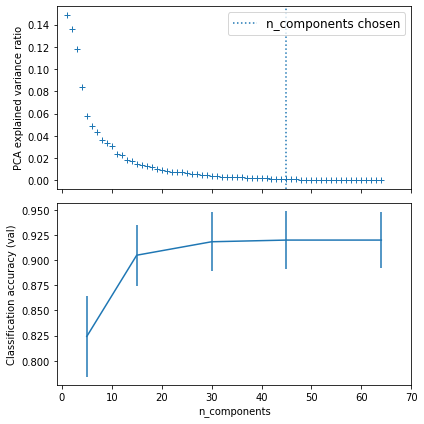

In [14]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))

ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

results        = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs      = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, 
               y='mean_test_score', 
               yerr='std_test_score',
               legend=False, 
               ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
plt.xlim(-1, 70)
plt.tight_layout()

### [Example: Feature map approximation for RBF kernels](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py)

- Shows how to use RBF Sample and Nystroem to approximate the feature map of an RBF kernel for classification with an SVM.

- Compares results between a linear SVM (original space), linear SVM (approx mapping), and a kernelized SVM.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn.decomposition import PCA
digits = datasets.load_digits(n_class=9)

In [16]:
n_samples = len(digits.data)
data      = digits.data / 16.
data     -= data.mean(axis=0)

# train on 1st half of the digits
# predict on 2nd half of digits
data_train, targets_train = (data[:n_samples // 2],
                             digits.target[:n_samples // 2])
data_test, targets_test   = (data[n_samples // 2:],
                             digits.target[n_samples // 2:])
# data_test = scaler.transform(data_test)

# Create a classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()

# create pipeline from kernel approximation and linear svm
feature_map_fourier  = RBFSampler(gamma=.2, random_state=1)
feature_map_nystroem = Nystroem(  gamma=.2, random_state=1)

fourier_approx_svm   = pipeline.Pipeline([("feature_map", 
                                           feature_map_fourier),
                                        ("svm", 
                                         svm.LinearSVC())])
nystroem_approx_svm = pipeline.Pipeline([("feature_map", 
                                          feature_map_nystroem),
                                        ("svm", 
                                         svm.LinearSVC())])

# fit and predict

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time  = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time  = time() - linear_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores, nystroem_scores = [],[]
fourier_times,  nystroem_times  = [],[]

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)

    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

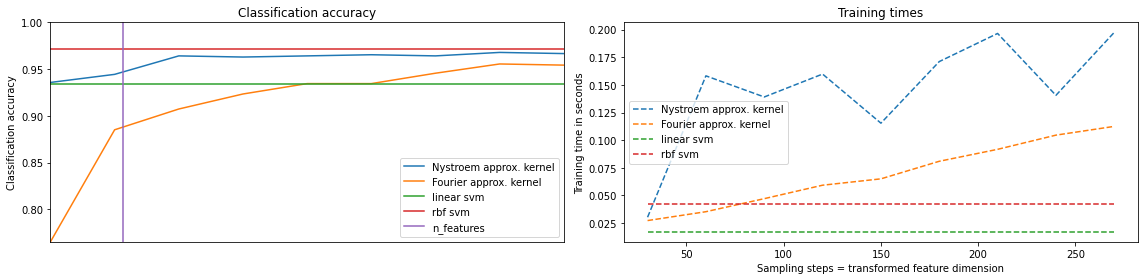

In [17]:
plt.figure(figsize=(16, 4))
accuracy = plt.subplot(121)
# second y axis for timings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, 
              nystroem_scores, 
              label="Nystroem approx. kernel")
timescale.plot(sample_sizes, 
               nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, 
              fourier_scores, 
              label="Fourier approx. kernel")
timescale.plot(sample_sizes, 
               fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], 
               sample_sizes[-1]],
              [linear_svm_score, 
               linear_svm_score], 
              label="linear svm")

timescale.plot([sample_sizes[0], 
                sample_sizes[-1]],
               [linear_svm_time, 
                linear_svm_time], '--', 
               label='linear svm')

accuracy.plot([sample_sizes[0], 
               sample_sizes[-1]],
              [kernel_svm_score, 
               kernel_svm_score], 
              label="rbf svm")

timescale.plot([sample_sizes[0], 
                sample_sizes[-1]],
               [kernel_svm_time, 
                kernel_svm_time], '--', 
               label='rbf svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')
plt.tight_layout()

### [Regression Target Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html#sklearn.compose.TransformedTargetRegressor)

- Transforms targets y before fitting a regression model. The predictions are mapped back to the original space via an inverse transform. It takes as an argument the regressor that will be used for prediction, and the transformer that will be applied to the target variable.

In [18]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.compose import TransformedTargetRegressor as TTR
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)
X, y = X[:2000, :], y[:2000]  # select a subset of data

transformer = QuantileTransformer(output_distribution='normal')
regressor   = LinearRegression()
regr        = TTR(regressor=regressor,
                  transformer=transformer)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

regr.fit(X_train, y_train)

print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

raw_target_regr = LinearRegression().fit(X_train, y_train)

print('R2 score: {0:.2f}'.format(raw_target_regr.score(X_test, y_test)))

R2 score: 0.61
R2 score: 0.59


- If using simple transformations, you can pass a pair of functions instead. They define the transform and its inverse mapping.

In [21]:
def func(x):
    return np.log(x)
def inverse_func(x):
    return np.exp(x)

regr = TTR(regressor=regressor,
           func=func,
           inverse_func=inverse_func).fit(X_train, y_train)

print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

R2 score: 0.51


- The functions are verified to be the inverse of each other during each fit. `check_inverse=False` bypasses this check.

In [22]:
def inverse_func(x):
    return x

regr = TTR(regressor=regressor,
           func=func,
           inverse_func=inverse_func,
           check_inverse=False).fit(X_train, y_train)

print('R2 score: {0:.2f}'.format(regr.score(X_test, y_test)))

R2 score: -1.57


### [Example: Target Transforms prior to Regression Learning](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py)

- Uses two examples (one w/ synthetic data, another w/ Ames housing data.)

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor as TTR
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.utils.fixes import parse_version

In [8]:
# example #1 - synthetic data
# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}

- Generate synthetic random regression dataset
- Translate the targets (`y`) to all non-negative
- Add exponential function to make targets non-linear
- Plot probability density functions before & after applying the log functions.

In [9]:
X, y = make_regression(n_samples=10000, 
                       noise=100, 
                       random_state=0)
y       = np.expm1((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

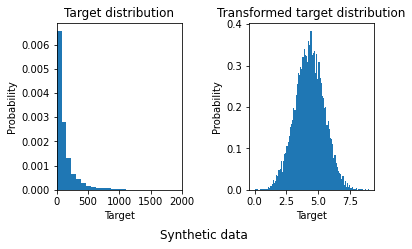

In [10]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_xlim([0, 2000])
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Synthetic data", y=0.06, x=0.53)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

- Fit linear model to original targets (Ridge regression). Fit should not be accurate due to non-linearity.
- Apply log function to linearize targets, allowing better prediction results.

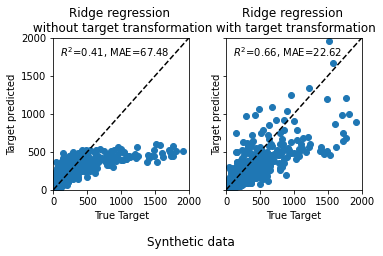

In [14]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr   = RidgeCV().fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0.scatter(y_test, y_pred)
ax0.plot([0, 2000], [0, 2000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), 
    median_absolute_error(y_test, y_pred)))
ax0.set_xlim([0, 2000])
ax0.set_ylim([0, 2000])

regr_trans = TTR(regressor=RidgeCV(),
                 func=np.log1p,
                 inverse_func=np.expm1).fit(X_train, y_train)
y_pred     = regr_trans.predict(X_test)

ax1.scatter(y_test, y_pred)
ax1.plot([0, 2000], [0, 2000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 2000])

f.suptitle("Synthetic data", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

### Example #2: Ames housing data

- Target variable: house sales price.
- Use [quantile transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer) to normalize targets.
- Apply a Ridge regression (CV'd) model.

In [15]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import QuantileTransformer, quantile_transform

ames = fetch_openml(name="house_prices", as_frame=True)

# Keep only numeric columns, drop columns with NaN or Inf values
X = ames.data.select_dtypes(np.number)
X = X.drop(columns=['LotFrontage', 'GarageYrBlt', 'MasVnrArea'])
y = ames.target
y_trans = quantile_transform(y.to_frame(),
                             n_quantiles=900,
                             output_distribution='normal',
                             copy=True).squeeze()

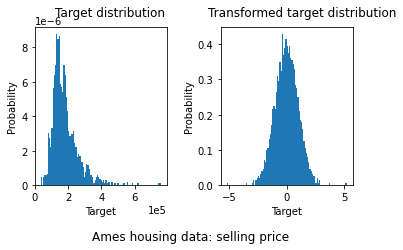

In [16]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.text(s='Target distribution', x=1.2e5, y=9.8e-6, fontsize=12)
ax0.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.text(s='Transformed target distribution', x=-6.8, y=0.479, fontsize=12)

f.suptitle("Ames housing data: selling price", y=0.04)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

- Transformer effect is weaker this time - but it results in higher $R^2$ and decreased MAE.
- Residual plot *without transformation* returns "reverse smile" shape - residual values varying based on predicted target value.
- Residual plot *with transformation* is more linear - indicating better fit.

Text(0.5, 0.035, 'Ames housing data: selling price')

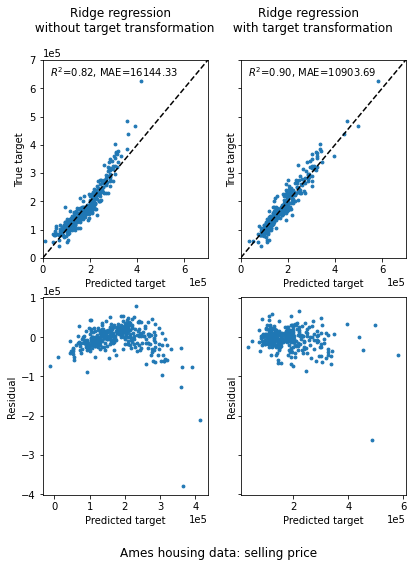

In [18]:
f, (ax0, ax1) = plt.subplots(2, 2, sharey='row', figsize=(6.5, 8))

regr   = RidgeCV().fit(X_train, y_train)
y_pred = regr.predict(X_test)

ax0[0].scatter(y_pred, y_test, s=8)
ax0[0].plot([0, 7e5], [0, 7e5], '--k')
ax0[0].set_ylabel('True target')
ax0[0].set_xlabel('Predicted target')
ax0[0].text(s='Ridge regression \n without target transformation', 
            x=-5e4, y=8e5, fontsize=12, 
            multialignment='center')

ax0[0].text(3e4, 64e4, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), 
    median_absolute_error(y_test, y_pred)))

ax0[0].set_xlim([0, 7e5])
ax0[0].set_ylim([0, 7e5])
ax0[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1[0].scatter(y_pred, (y_pred - y_test), s=8)
ax1[0].set_ylabel('Residual')
ax1[0].set_xlabel('Predicted target')
ax1[0].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

regr_trans = TTR(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900,
                                    output_distribution='normal')).fit(
    X_train, y_train)

y_pred = regr_trans.predict(X_test)

ax0[1].scatter(y_pred, y_test, s=8)
ax0[1].plot([0, 7e5], [0, 7e5], '--k')
ax0[1].set_ylabel('True target')
ax0[1].set_xlabel('Predicted target')
ax0[1].text(s='Ridge regression \n with target transformation', x=-5e4,
            y=8e5, fontsize=12, multialignment='center')
ax0[1].text(3e4, 64e4, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax0[1].set_xlim([0, 7e5])
ax0[1].set_ylim([0, 7e5])
ax0[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1[1].scatter(y_pred, (y_pred - y_test), s=8)
ax1[1].set_ylabel('Residual')
ax1[1].set_xlabel('Predicted target')
ax1[1].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

f.suptitle("Ames housing data: selling price", y=0.035)

### [Feature Unions](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion)

- Combines a list of transformers into a single object.
- Each transformer is fitted *independently*.
- Transforms are applied in *parallel*. Resulting feature matrices are merged side-by-side.
- Feature Unions cannot check whether two transformers return identical features - only produces a union when features are disjoint.
- Built with a list of `(key,value)` pairs: key = arbitrary name string; value = estimator object.

In [20]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, KernelPCA
estimators = [('linear_pca', PCA()), 
              ('kernel_pca', KernelPCA())]

combined = FeatureUnion(estimators); print(combined)

FeatureUnion(transformer_list=[('linear_pca', PCA()),
                               ('kernel_pca', KernelPCA())])


- Shorthand notation: `make_union`. (Doesn't require explicit component names.)
- Individual steps can be replaced using `set_params`, and ignored using `drop`.

In [21]:
combined.set_params(kernel_pca='drop')

FeatureUnion(transformer_list=[('linear_pca', PCA()), ('kernel_pca', 'drop')])

### [Example: Feature Union](https://scikit-learn.org/stable/auto_examples/compose/plot_feature_union.html#sphx-glr-auto-examples-compose-plot-feature-union-py)

In [22]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

In [24]:
iris      = load_iris()
X, y      = iris.data, iris.target
pca       = PCA(n_components=2)
selection = SelectKBest(k=1)
combined_features = FeatureUnion([("pca", pca), 
                                  ("univ_select", selection)])

X_features = combined_features.fit(X, y).transform(X)
print("Combined space has", X_features.shape[1], "features")

svm      = SVC(kernel="linear")
pipeline = Pipeline([("features", combined_features), 
                     ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, 
                           param_grid=param_grid, 
                           #verbose=10).fit(X, y)
                          ).fit(X,y)
print(grid_search.best_estimator_)

Combined space has 3 features
Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=3)),
                                                ('univ_select',
                                                 SelectKBest(k=1))])),
                ('svm', SVC(C=10, kernel='linear'))])


### [Column Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer)

- Datasets usually contain multiple feature types (floats, integers, text, dates, ...) which require individual preprocessing or feature extraction steps.

- The usual method for doing this is with [pandas](https://pandas.pydata.org/), which can be problematic. (Test data statistics leaking into cross-validation, needing to include preprocessing params in a search, ...).

- CT enables using per-column transforms in a leakage-safe Pipeline. It works on arrays, sparse matrices & Pandas dataframes.

### Simple Example

- Encode `cities` as a category with [One-Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)
- Apply a [Count Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) to `titles`
- Remaining columns can be ignored (`remainder="drop"`).
- Use a *combined name* (ex: `city_category`) to define a multiple-extraction method on a given column.

In [25]:
import pandas as pd
X = pd.DataFrame(
    {'city': ['London', 'London', 'Paris', 'Sallisaw'],
     'title': ["His Last Bow", "How Watson Learned the Trick",
               "A Moveable Feast", "The Grapes of Wrath"],
     'expert_rating': [5, 3, 4, 5],
     'user_rating': [4, 5, 4, 3]})

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(dtype='int'),['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder='drop')

print(column_trans.fit(X),"\n")
print(column_trans.get_feature_names(),"\n")
print(column_trans.transform(X).toarray())

ColumnTransformer(transformers=[('city_category', OneHotEncoder(dtype='int'),
                                 ['city']),
                                ('title_bow', CountVectorizer(), 'title')]) 

['city_category__x0_London', 'city_category__x0_Paris', 'city_category__x0_Sallisaw', 'title_bow__bow', 'title_bow__feast', 'title_bow__grapes', 'title_bow__his', 'title_bow__how', 'title_bow__last', 'title_bow__learned', 'title_bow__moveable', 'title_bow__of', 'title_bow__the', 'title_bow__trick', 'title_bow__watson', 'title_bow__wrath'] 

[[1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1]]


- Above: [Count Vecorizer]() expects a 1D array - hence the columns were specified with a string (`title`). [One Hot Encoder]() expects 2D data, so you need to specify the column as a *list of strings* (`['city]`).

- Columns can be specified as a list of items, an integer array, a slice, a boolean mask, or by using [make_column_selector](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html#sklearn.compose.make_column_selector).

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector as MCS

ct = ColumnTransformer([
      ('scale', 
       StandardScaler(), 
       MCS(dtype_include=np.number)),
      ('onehot', 
       OneHotEncoder(), 
       MCS(pattern='city', dtype_include=object))]).fit_transform(X)

print(ct)

[[ 0.90453403  0.          1.          0.          0.        ]
 [-1.50755672  1.41421356  1.          0.          0.        ]
 [-0.30151134  0.          0.          1.          0.        ]
 [ 0.90453403 -1.41421356  0.          0.          1.        ]]


- Keep the remaining columns with `remainder='passthrough'`. The values are appended to the end of the result.

In [30]:
ct = ColumnTransformer(
    [('city_category', 
      OneHotEncoder(dtype='int'),
      ['city']),
     ('title_bow', 
      CountVectorizer(), 
      'title')],
    remainder='passthrough').fit_transform(X)

print(ct)

[[1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 5 4]
 [1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 3 5]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 4 4]
 [0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 5 3]]


- `remainder` can point to an estimator to transform the remaining columns.

In [31]:
from sklearn.preprocessing import MinMaxScaler

ct = ColumnTransformer(
    [('city_category', 
      OneHotEncoder(), 
      ['city']),
     ('title_bow', 
      CountVectorizer(), 
      'title')],
    remainder=MinMaxScaler()).fit_transform(X)[:, -2:]

print(ct)

[[1.  0.5]
 [0.  1. ]
 [0.5 0.5]
 [1.  0. ]]


- `make_column_transformer` creates a [Column Transformer]() object.

In [32]:
from sklearn.compose import make_column_transformer as MCT

ct = MCT(
    (OneHotEncoder(), ['city']),
    (CountVectorizer(), 'title'),
    remainder=MinMaxScaler())

print(ct)

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(), ['city']),
                                ('countvectorizer', CountVectorizer(),
                                 'title')])


### Visualization

- HTML equivalents are available in Jupyter using [set_config](https://scikit-learn.org/stable/modules/generated/sklearn.set_config.html#sklearn.set_config)

- HTML can also be written to a file with [estimator_html_repr](https://scikit-learn.org/stable/modules/generated/sklearn.utils.estimator_html_repr.html#sklearn.utils.estimator_html_repr)

In [33]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context
column_trans  

ColumnTransformer(transformers=[('city_category', OneHotEncoder(dtype='int'),
                                 ['city']),
                                ('title_bow', CountVectorizer(), 'title')])

In [35]:
from sklearn.utils import estimator_html_repr
with open('my_estimator.html', 'w') as f:  
    f.write(estimator_html_repr(ct))

### [Example Column Transformer](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py)

- Numeric data is mean-imputed, then standard-scaled.
- Category data: missing data is replaced with 'missing', then one-hot encoded.
- Two column dispatch mechanisms are shown: by column names, by column data types.
- The steps are integrated into a Pipeline with a simple classifier.

In [36]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [37]:
np.random.seed(0)

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

In [39]:
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())])

categorical_features    = ['embarked', 'sex', 'pclass']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,     numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

from sklearn import set_config
set_config(display='diagram')
clf

model score: 0.790


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['embarked', 'sex',
                                                   'pclass'])])),
                ('classifier', LogisticRegression())])

- When dealing with a cleaned dataset, the preprocessing can be automatic by using the data types of the column to decide whether to treat a column as a numerical or categorical feature with [make_column_selector](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html#sklearn.compose.make_column_selector). 

- First, let’s only select a subset of columns to simplify our example.

In [40]:
subset_feature = ['embarked', 'sex', 'pclass', 'age', 'fare']
X_train, X_test = X_train[subset_feature], X_test[subset_feature]

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 1118 to 684
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   embarked  1045 non-null   category
 1   sex       1047 non-null   category
 2   pclass    1047 non-null   float64 
 3   age       841 non-null    float64 
 4   fare      1046 non-null   float64 
dtypes: category(2), float64(3)
memory usage: 35.0 KB


- `embarked` and `sex` are tagged as categories when loading the data with fetch_openml. We can use this information to dispatch the categorical columns to the categorical_transformer and the remaining columns to the numerical_transformer.

In [41]:
from sklearn.compose import make_column_selector as selector

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer,     selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())]
              ).fit(X_train, y_train)

print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.794


- This score doesn't match the previous pipeline's score becase the dtype-based selector treats the pclass columns as a numeric features instead of a category.

In [42]:
print(selector(dtype_exclude="category")(X_train))
print(selector(dtype_include="category")(X_train))

['pclass', 'age', 'fare']
['embarked', 'sex']


- *Grid search* can be used on the steps defined in the `ColumnTransformer`, together with the classifier’s hyperparameters as part of the Pipeline. 

- Search for the best imputer strategy (for numeric preprocessing) and regularization parameter (for logistic regression) using `GridSearchCV`.

In [43]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf, param_grid, cv=10)
set_config(display='diagram')
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f4d3f7bce50>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f4d3f7bc4f0>)])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1.0, 10, 100],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']})

In [44]:
grid_search.fit(X_train, y_train)

print(f"Best params:", grid_search.best_params_)

Best params: {'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'}


In [45]:
print(f"Internal CV score: {grid_search.best_score_:.3f}")

Internal CV score: 0.784


In [46]:
# search results as a pandas dataframe
import pandas as pd

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[["mean_test_score", "std_test_score",
            "param_preprocessor__num__imputer__strategy",
            "param_classifier__C"
            ]].head(5)

,mean_test_score,std_test_score,param_preprocessor__num__imputer__strategy,param_classifier__C
0,0.784167,0.035824,mean,0.1
2,0.780366,0.032722,mean,1
1,0.780348,0.037245,median,0.1
4,0.779414,0.033105,mean,10
6,0.779414,0.033105,mean,100


- The best hyper-parameters have to be used to re-fit a final model on the full training set. We can evaluate that final model on held out test data that was not used for hyperameter tuning.

In [47]:
print(("best logistic regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best logistic regression from grid search: 0.794
